# Example and validation

- Dimiceli, V.E., Piltz, S.F. and Amburn, S.A., 2011, October. Estimation of black globe temperature for calculation of the wet bulb globe temperature index. In Proceedings of the World Congress on Engineering and Computer Science (Vol. 2, pp. 19-21).
- Dimiceli, V.E. and Piltz, S.F., 2015. Estimation of Black Globe Temperature for Calculations of the WBGT Index. WBGT research paper.



In [1]:
# Import Libaries
import pandas as pd
import numpy as np

# Import this from Tg_Dimiceli.py
from Tg_Dimiceli import GlobeTemperatureCalculator

#### Load exmple data


In [2]:
#prelim test
df = pd.read_csv('./data.csv')
df.head()

,Time,Date,fdb,fdif,Ta_C,Td_C,P_mb,S_W_per_m2,cos_z,u_m_per_sec,...,h,Tw_C,ea,epsa,B,C,Tg_C,Tg_F,e,actual_Tg_C
0,13:00,7/3/2010,0.75,0.25,26.26,17.21,973.62,193.04,0.9714,1.812,...,0.101274,20.947813,18.556686,0.872735,1678945078,306605873.4,3.173446e+01,89.1220,19.566616,31.55
1,14:00,7/3/2010,0.75,0.25,28.80,17.57,973.71,448.70,0.9244,2.164,...,0.132570,21.454124,18.591840,0.872971,3979819932,444878843.2,3.774140e+01,99.9345,20.009162,37.16
2,13:00,7/10/2010,0.75,0.25,29.50,16.20,971.03,173.00,0.9689,2.734,...,0.098525,20.461984,16.748722,0.860047,1506448296,378649115.5,3.786491e+08,92.2570,33.476131,33.58
3,14:00,7/10/2010,0.75,0.25,31.06,16.59,971.37,387.98,0.9226,3.860,...,0.127661,20.860842,16.938913,0.861436,3444243993,599274858.9,3.680445e+01,98.2480,36.804446,37.47


### Check Tg calculation
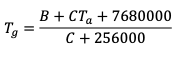

In [3]:
def calculate_row_globe_temperature_with_B_C(row):
    # Convert wind speed from meters per second to meters per second if needed
    wind_speed_m_per_s = row['u_m_per_sec']  # Assuming 'u_m_per_sec' is already in m/s
    
    # Convert atmospheric pressure from millibars to Pascals (Pa)
    pressure_pa = row['P_mb']

    # Initialize the calculator with the values from the row, including B and C if they exist in the row
    calculator = GlobeTemperatureCalculator(
        S=row['S_W_per_m2'],
        f_db=row['fdb'],
        f_dif=row['fdif'],
        T_d=row['Td_C'],  # Dew point temperature in Celsius
        T_a=row['Ta_C'],  # Actual air temperature in Celsius
        P=pressure_pa,  # pressure in Pa
        h=row['h'],  # Use 'h' value from the DataFrame
        u=wind_speed_m_per_s,
        z=np.degrees(np.arccos(row['cos_z'])),  # Convert from cos(z) to degrees
        B=row.get('B', None),  # Use B from the DataFrame if it exists
        C=row.get('C', None)   # Use C from the DataFrame if it exists
    )

    # Calculate and return the globe temperature in Celsius
    Tg_C = calculator.calculate_globe_temperature()
    # Convert the result to Fahrenheit
    return (Tg_C * 9/5) + 32

# Apply the function to each row of the DataFrame
df['my_Tg_F'] = df.apply(calculate_row_globe_temperature_with_B_C, axis=1)

# Display the DataFrame with the new calculated globe temperatures in Fahrenheit
df[['Time', 'Date', 'Tg_C', 'Tg_F', 'my_Tg_F']]

,Time,Date,Tg_C,Tg_F,my_Tg_F
0,13:00,7/3/2010,3.173446e+01,89.1220,89.122025
1,14:00,7/3/2010,3.774140e+01,99.9345,99.934514
2,13:00,7/10/2010,3.786491e+08,92.2570,92.257035
3,14:00,7/10/2010,3.680445e+01,98.2480,98.248003


### Check C calculation

In [4]:
# Re-define the function to calculate the constant C after the reset
def calculate_C(h, u):
    """
    Calculate the constant C using the formula given in the image.

    Parameters:
    h (float): Convective heat transfer coefficient.
    u (float): Wind speed in meters per second (m/s).

    Returns:
    float: The calculated constant C.
    """

    # The constant factor as given in the formula
    constant_factor = 5.3865e-8

    u = u * 3600.0 #convert to m/h from m/s
    
    # Calculate C using the provided formula
    C = (h * u**0.58) / constant_factor
    return C

df['C_cal'] = df.apply(lambda row: calculate_C(row['h'], row['u_m_per_sec']), axis=1)
df['C_cal'] = df['C_cal'].apply(lambda x: f"{x:.1f}")

df[['C', 'C_cal']]

,C,C_cal
0,306605873.4,306605873.6
1,444878843.2,444878844.6
2,378649115.5,378649115.2
3,599274858.9,599274860.2


### Check B calculation
- atmospheric vapor pressure, e_a
- thermal emissivity, epsilon_a
- constant B

#### Check e_a calculation

In [5]:
def calculate_e_a(T_d, T_a, P):
    """Calculate the atmospheric vapor pressure, e_a."""
    term1 = np.exp(17.67 * (T_d - T_a)/(T_d+243.5))
    term2 = 1.0007 + 0.00000346 * P
    term3 = 6.112 * np.exp((17.502 * T_a) / (240.97 + T_a))
    e_a = term1 * term2 * term3
    return e_a

df['e_a_cal'] = df.apply(lambda row: calculate_e_a(row['Td_C'], row['Ta_C'], row['P_mb']), axis=1)
df[['ea', 'e_a_cal']]

,ea,e_a_cal
0,18.556686,18.556383
1,18.591840,18.591536
2,16.748722,16.748448
3,16.938913,16.938636


#### Check epsilon_a calculation

In [6]:
def calculate_epsilon_a(e_a):
    """Calculate the thermal emissivity, epsilon_a."""
    epsilon_a = 0.575 * e_a ** (1/7)
    return epsilon_a

df['epsilon_a_cal'] = df.apply(lambda row: calculate_epsilon_a(row['ea']), axis=1)

df[['epsa', 'epsilon_a_cal']]

,epsa,epsilon_a_cal
0,0.872735,0.872735
1,0.872971,0.872971
2,0.860047,0.860047
3,0.861436,0.861436


#### Check B calculation

In [7]:
def calculate_B(cos_z, f_db, f_dif, epsilon_a, T_a, S):
    """Calculate the constant B."""
    
    stephan_boltzmann_constant = 5.67e-8 

    # T_a = (T_a * 9/5) + 32

    term1 = f_db / (4 * cos_z * stephan_boltzmann_constant)
    term2 = (1.2 * f_dif) / stephan_boltzmann_constant
    term3 = epsilon_a * T_a**4
    return (term1 + term2) * S + term3

In [8]:
df.columns

Index(['Time', 'Date', 'fdb', 'fdif', 'Ta_C', 'Td_C', 'P_mb', 'S_W_per_m2',
       'cos_z', 'u_m_per_sec', 'u_m_per_hr', 'Rh', 'h', 'Tw_C', 'ea', 'epsa',
       'B', 'C', 'Tg_C', 'Tg_F', 'e', 'actual_Tg_C', 'my_Tg_F', 'C_cal',
       'e_a_cal', 'epsilon_a_cal'],
      dtype='object')

In [9]:
df['B_cal'] = df.apply(lambda row: calculate_B(row['cos_z'], row['fdb'], row['fdif'], row['epsa'], row['Ta_C'], row['S_W_per_m2']), axis=1)
df['B_cal'] = df['B_cal'].apply(lambda x: f"{x:.1f}")
df[['B', 'B_cal']]

,B,B_cal
0,1678945078,1678945078.1
1,3979819932,3979819931.7
2,1506448296,1506448295.9
3,3444243993,3444243992.8
